In [1]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.optim import Adagrad
import torch
import torch.nn as nn


train_dataset = MNIST(root='cache_mnist', train=True, transform=ToTensor(), download=True)
test_dataset = MNIST(root='cache_mnist', train=False, transform=ToTensor(), download=True)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=3)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=1000, num_workers=3)


net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
)
criterion = nn.CrossEntropyLoss()
optimizer = Adagrad(net.parameters(), lr=1e-2)


for _ in range(3):

    net.train()
    losses = []

    for x, y in train_loader:
        loss = criterion(net(x), y)
        losses.append(loss.item())
        loss.backward()
        print(format(loss.item(), '.4f'), end='\r')
        optimizer.step()
        optimizer.zero_grad()

    print(sum(losses) / len(train_loader))


0.3021078381512656
0.17924543830957304
0.1472231224179268


In [2]:
with torch.no_grad():

    true, pred = [], []

    for x, y in test_loader:
        pred.append(net(x).argmax(dim=1, keepdim=True))
        true.append(y)
        # true.append(torch.eye(10)[y.to(torch.int64)])

    true = torch.cat(true)
    pred = torch.cat(pred)

In [3]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(true, pred)

# import numpy as np
# conf -= np.diagflat(np.diagonal(conf))

conf

array([[ 964,    0,    1,    1,    0,    5,    7,    1,    1,    0],
       [   0, 1116,    3,    2,    0,    1,    3,    2,    8,    0],
       [   7,    3,  983,    7,    5,    1,    5,    8,   12,    1],
       [   0,    0,   10,  973,    0,    6,    0,    8,   11,    2],
       [   1,    1,    4,    0,  937,    0,    9,    4,    5,   21],
       [   8,    1,    0,   19,    4,  832,   11,    0,   11,    6],
       [   6,    3,    2,    1,    3,    7,  932,    0,    4,    0],
       [   2,    7,   20,    3,    2,    1,    0,  979,    2,   12],
       [   3,    2,    3,   18,    5,    4,    8,    6,  922,    3],
       [   8,    6,    1,   12,   13,    4,    1,    5,    7,  952]])

In [4]:
# one-hot vector example
indexer = torch.tensor(range(9, -1, -1))  # int64 reverse indexer
torch.eye(10)[indexer]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [5]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[ 964    0    1    1    0    5    7    1    1    0]
 [   0 1116    3    2    0    1    3    2    8    0]
 [   7    3  983    7    5    1    5    8   12    1]
 [   0    0   10  973    0    6    0    8   11    2]
 [   1    1    4    0  937    0    9    4    5   21]
 [   8    1    0   19    4  832   11    0   11    6]
 [   6    3    2    1    3    7  932    0    4    0]
 [   2    7   20    3    2    1    0  979    2   12]
 [   3    2    3   18    5    4    8    6  922    3]
 [   8    6    1   12   13    4    1    5    7  952]]


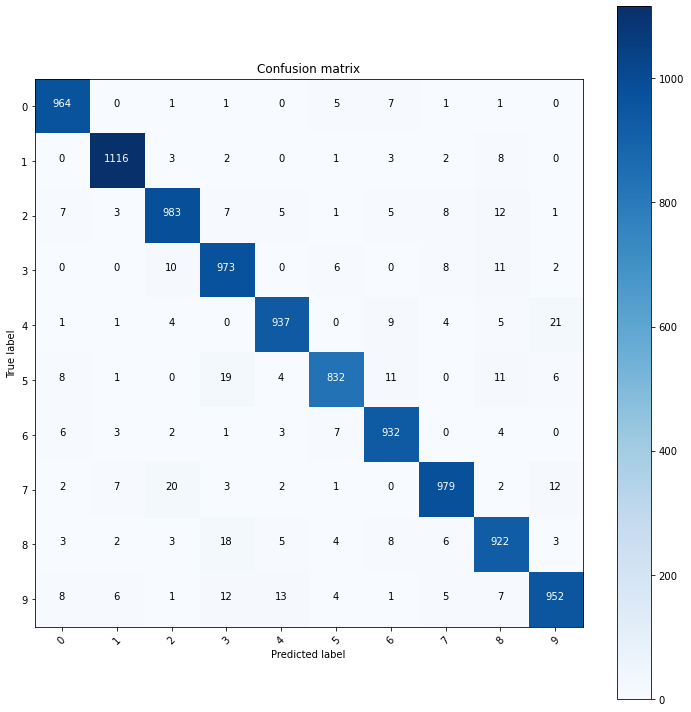

In [6]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(conf, range(10))


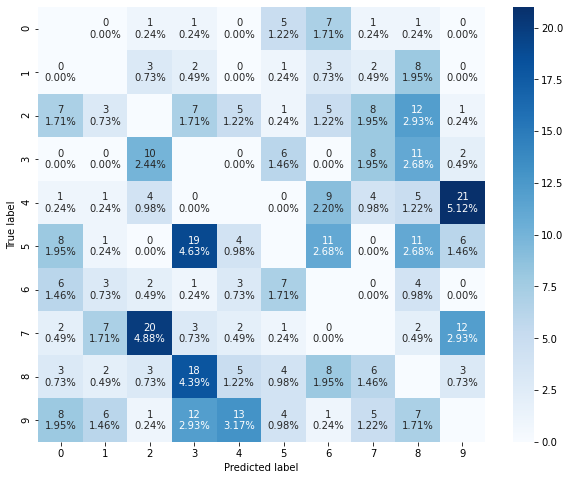

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# src: https://github.com/DTrimarchi10/confusion_matrix
def draw_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          omit_diagonal=False,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    """
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    percent:       If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    omit_diagonal: If True, omit diagonal elements of confusion matrix.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
    title:         Title for the heatmap. Default is None.
    """

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    if omit_diagonal:
        cf -= np.diagflat(np.diagonal(cf))

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for _ in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    if omit_diagonal:
        box_labels[np.diag_indices_from(box_labels)] = ""

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize == None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks == False:
        #Do not show categories if xyticks is False
        categories=False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)


draw_confusion_matrix(conf,
                      categories=range(10),
                      cmap='Blues',
                      omit_diagonal=True,
                      sum_stats=False,
                      figsize=(10, 8),
                      )